In [1]:
import keypoint_moseq as kpms
import numpy as np
import os, shutil
import math 
# import joblib

In [2]:
project_dir = r'R:\PBS\LiPatel_Labs\General\kmps\valen\withPorts'
config = lambda: kpms.load_config(project_dir)

In [3]:
# make sure the DLC config.yaml file is in the project_dir
dlc_config = project_dir + '\config.yaml'
kpms.setup_project(project_dir, deeplabcut_config=dlc_config, overwrite=True)

In [18]:
kpms.update_config(
    project_dir,
    video_dir = project_dir + '/videos/',
    anterior_bodyparts=['nose'], posterior_bodyparts=['tailbase'], 
    use_bodyparts = ['nose',  'head',  'shoulder', 'body', 'tailbase', 
                     'leftarm', 'rightarm', 'leftleg', 'rightleg',
                     'sucroseport', 'topnoseport', 'botnoseport'])                     

In [19]:
# divide the training data into 2 subsets to prevent dead kernel
# adjsut subset_size based on your case
def find_files_with_suffix(root_folder, file_suffix):
    file_paths = []  # List to store full paths of matching files
    for dirpath, dirnames, files in os.walk(root_folder):
        # Check each file in the directory
        for file in files:
            if file.endswith(file_suffix):
                full_path = os.path.join(dirpath, file)
                file_paths.append(full_path)
    return file_paths
    
def divide_into_batches(file_paths, num_batches):
    total_items = len(file_paths)
    batch_size = math.ceil(total_items / num_batches)  # Calculate batch size using the ceiling function
    return [file_paths[i:i + batch_size] for i in range(0, total_items, batch_size)]

num_batches = 6
keypoint_data_path = project_dir + '/predictions/'
file_suffix = 'filtered.h5'
file_paths = find_files_with_suffix(keypoint_data_path, file_suffix)
subsets = divide_into_batches(file_paths, num_batches) 

In [20]:
for index, batch in enumerate(subsets):
    print(f"Batch {index + 1}: {batch}")

Batch 1: ['R:\\PBS\\LiPatel_Labs\\General\\kmps\\valen\\withPorts/predictions/Box3-20240410T090517-100516_19508DLC_resnet50_medpcJun4shuffle1_300000_filtered.h5', 'R:\\PBS\\LiPatel_Labs\\General\\kmps\\valen\\withPorts/predictions/Box1-20240415T114127-124126_19474DLC_resnet50_medpcJun4shuffle1_300000_filtered.h5']
Batch 2: ['R:\\PBS\\LiPatel_Labs\\General\\kmps\\valen\\withPorts/predictions/Box2-20240410T090517-100516_19507DLC_resnet50_medpcJun4shuffle1_300000_filtered.h5', 'R:\\PBS\\LiPatel_Labs\\General\\kmps\\valen\\withPorts/predictions/Box2-20240508T093204-103204_19480DLC_resnet50_medpcJun4shuffle1_300000_filtered.h5']
Batch 3: ['R:\\PBS\\LiPatel_Labs\\General\\kmps\\valen\\withPorts/predictions/Box2-20240415T114127-124126_19475DLC_resnet50_medpcJun4shuffle1_300000_filtered.h5', 'R:\\PBS\\LiPatel_Labs\\General\\kmps\\valen\\withPorts/predictions/Box1-20240508T104216-114215_19510DLC_resnet50_medpcJun4shuffle1_300000_filtered.h5']
Batch 4: ['R:\\PBS\\LiPatel_Labs\\General\\kmps\\val

In [21]:
# load body parts
coordinates,confidences,bodyparts = kpms.load_keypoints(subsets[0],'deeplabcut')
data,metadata = kpms.format_data(coordinates,confidences, **config())

Loading keypoints: 100%|██████████████████| 2/2 [00:01<00:00,  1.90it/s]


>=90.0% of variance exlained by 4 components.


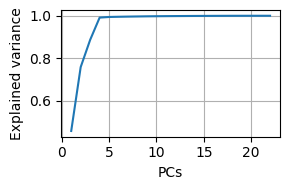

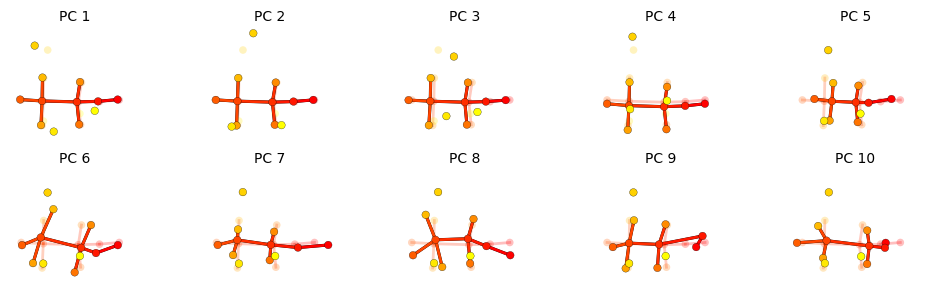

In [22]:
# calculate PCA
pca = kpms.fit_pca(**data, **config())
kpms.save_pca(pca, project_dir)
kpms.print_dims_to_explain_variance(pca, 0.9)
kpms.plot_scree(pca, project_dir=project_dir)
kpms.plot_pcs(pca, project_dir=project_dir, **config())

In [23]:
# change the laten_dim to the number of components that explain >90% of variance
dim = 4
kpms.update_config(project_dir, latent_dim=dim)

In [24]:
# initiate a new model
model = kpms.init_model(data, pca=pca, **config())
model = kpms.update_hypparams(model, kappa=10e6)

Outputs will be saved to
R:\PBS\LiPatel_Labs\General\kmps\valen\withPorts\2025_04_07-16_29_59


 49%|█████████████████▏                 | 25/51 [01:27<01:34,  3.62s/it]

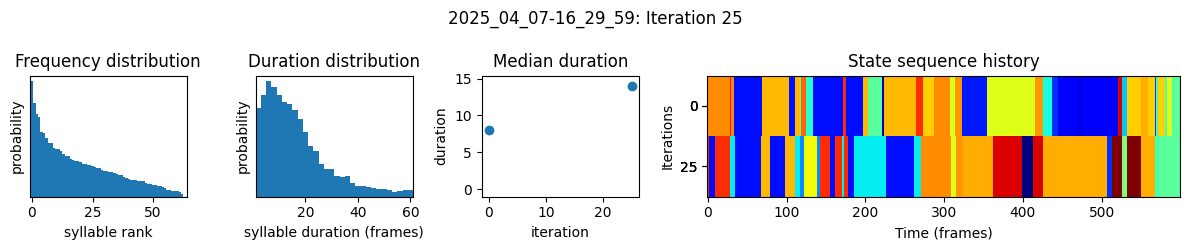

 98%|██████████████████████████████████▎| 50/51 [02:58<00:03,  3.56s/it]

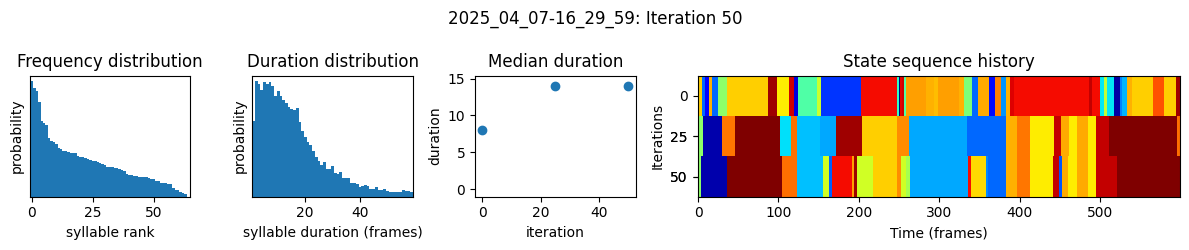

100%|███████████████████████████████████| 51/51 [03:04<00:00,  3.61s/it]


In [25]:
num_ar_iters = 50

model, model_name = kpms.fit_model(
    model, data, metadata, project_dir,
    ar_only=True, num_iters=num_ar_iters)

Outputs will be saved to
R:\PBS\LiPatel_Labs\General\kmps\valen\withPorts\2025_04_07-16_29_59


  5%|█▋                                | 25/501 [01:39<32:15,  4.07s/it]

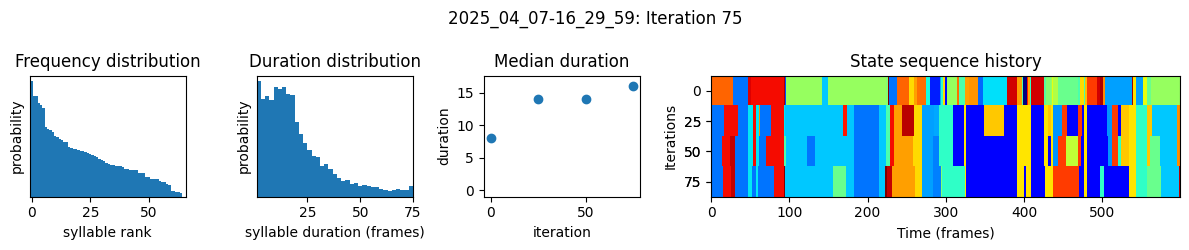

 10%|███▍                              | 50/501 [03:22<30:12,  4.02s/it]

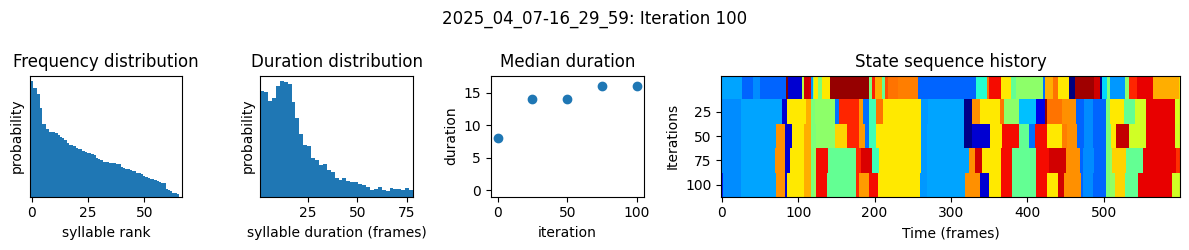

 15%|█████                             | 75/501 [05:04<29:03,  4.09s/it]

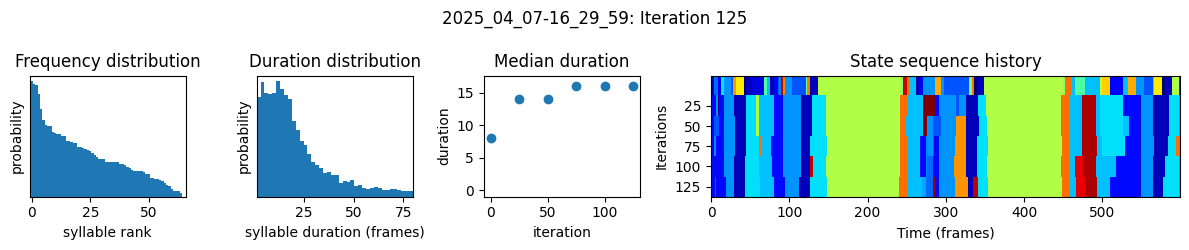

 20%|██████▌                          | 100/501 [06:46<26:51,  4.02s/it]

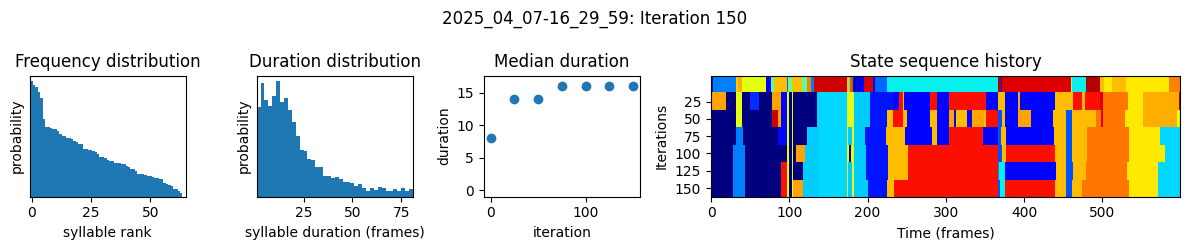

 25%|████████▏                        | 125/501 [08:27<26:19,  4.20s/it]

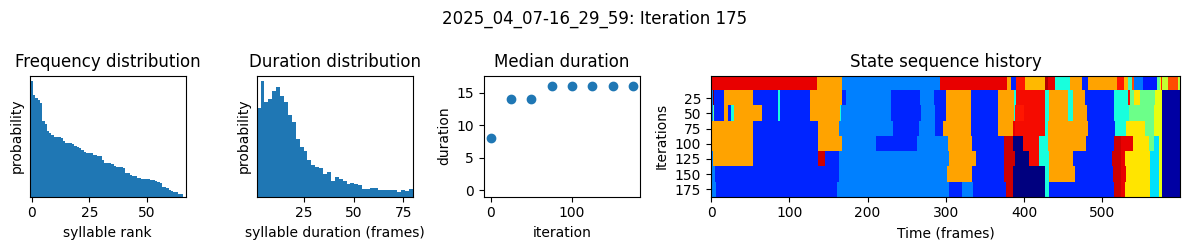

 30%|█████████▉                       | 150/501 [10:06<22:42,  3.88s/it]

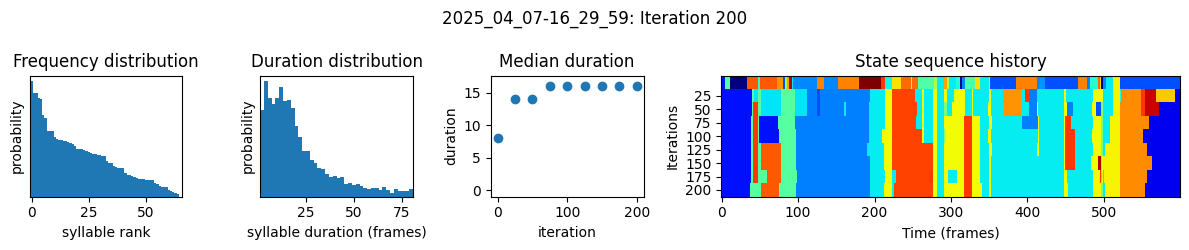

 35%|███████████▌                     | 175/501 [11:45<21:03,  3.88s/it]

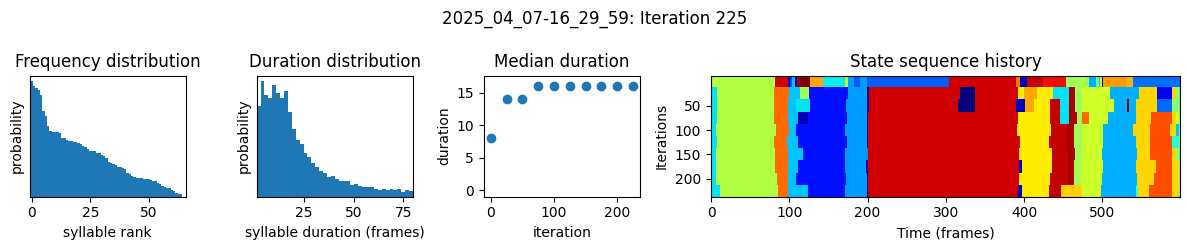

 40%|█████████████▏                   | 200/501 [13:23<19:13,  3.83s/it]

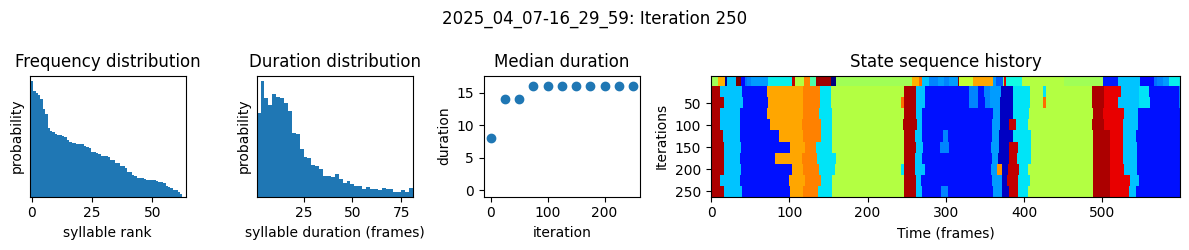

 45%|██████████████▊                  | 225/501 [15:01<17:50,  3.88s/it]

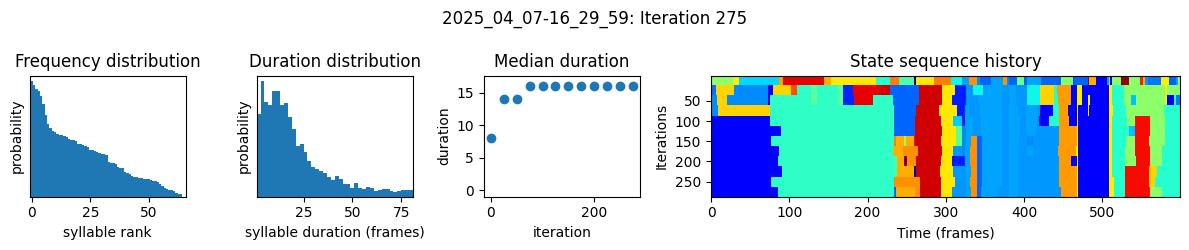

 50%|████████████████▍                | 250/501 [16:40<16:16,  3.89s/it]

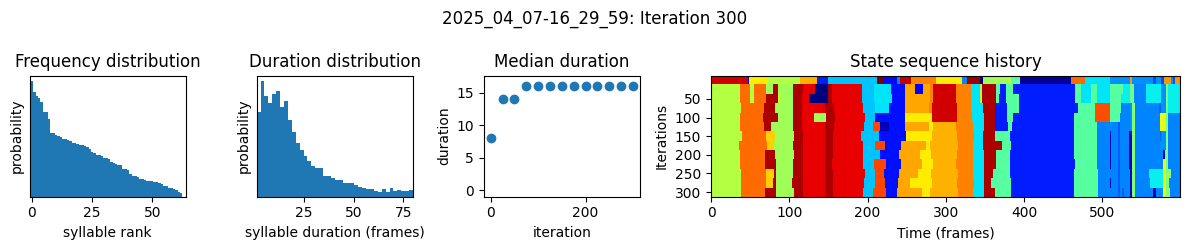

 55%|██████████████████               | 275/501 [18:19<14:39,  3.89s/it]

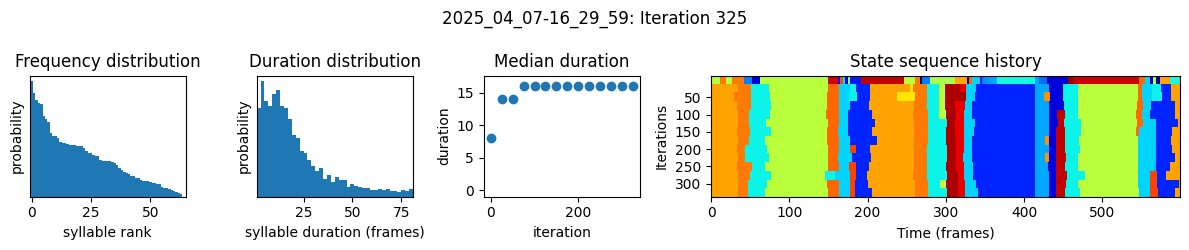

 60%|███████████████████▊             | 300/501 [19:58<12:59,  3.88s/it]

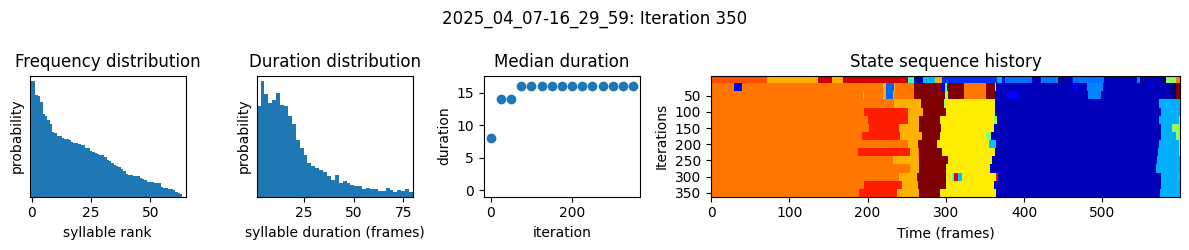

 65%|█████████████████████▍           | 325/501 [21:36<11:30,  3.92s/it]

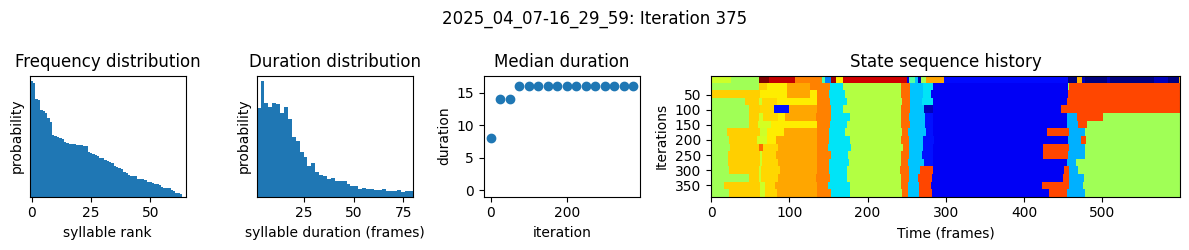

 70%|███████████████████████          | 350/501 [23:15<09:43,  3.86s/it]

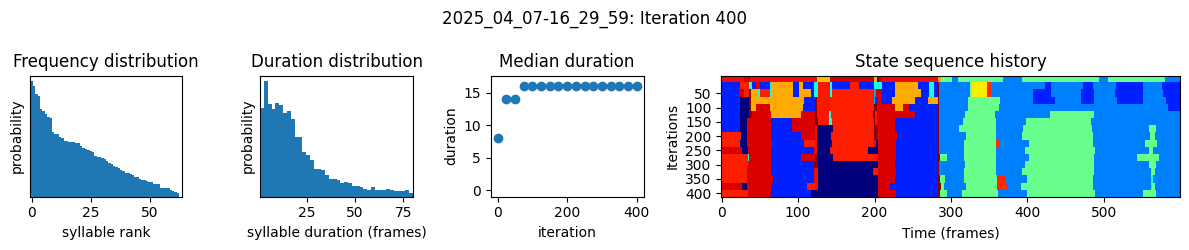

 75%|████████████████████████▋        | 375/501 [24:53<08:05,  3.86s/it]

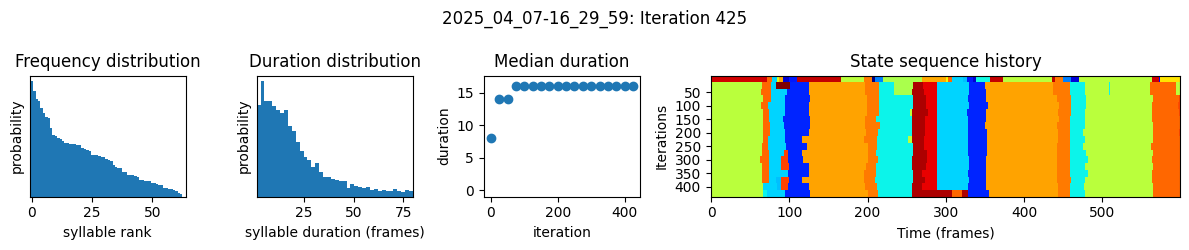

 80%|██████████████████████████▎      | 400/501 [26:32<06:41,  3.98s/it]

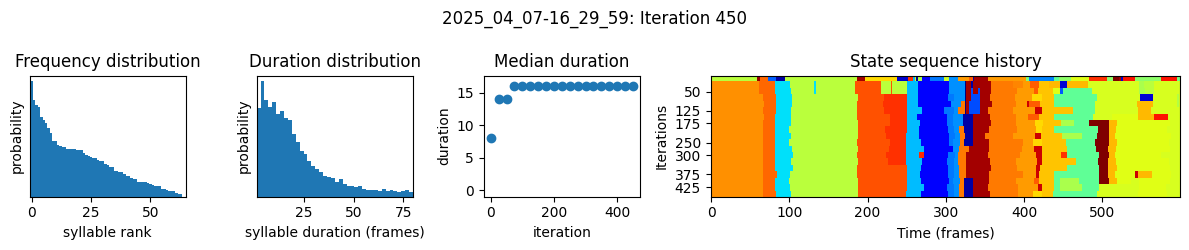

 85%|███████████████████████████▉     | 425/501 [28:14<05:13,  4.12s/it]

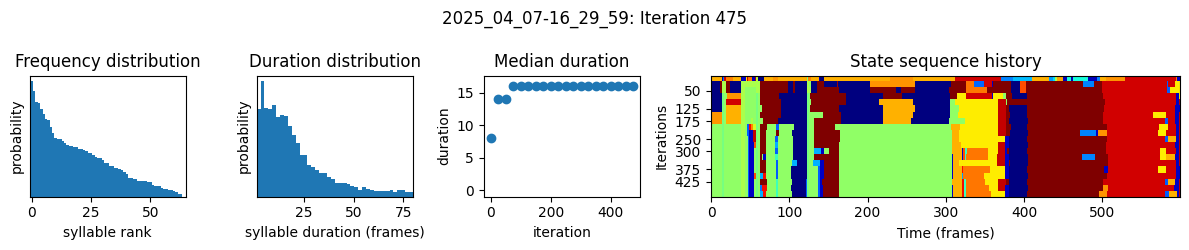

 90%|█████████████████████████████▋   | 450/501 [29:55<03:19,  3.90s/it]

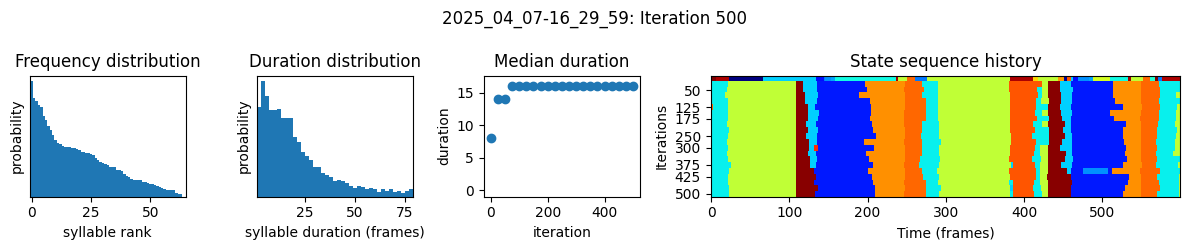

 95%|███████████████████████████████▎ | 475/501 [31:34<01:40,  3.87s/it]

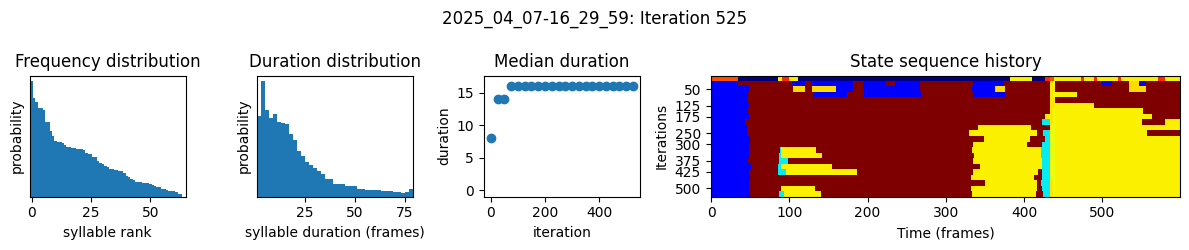

100%|████████████████████████████████▉| 500/501 [33:14<00:03,  3.93s/it]

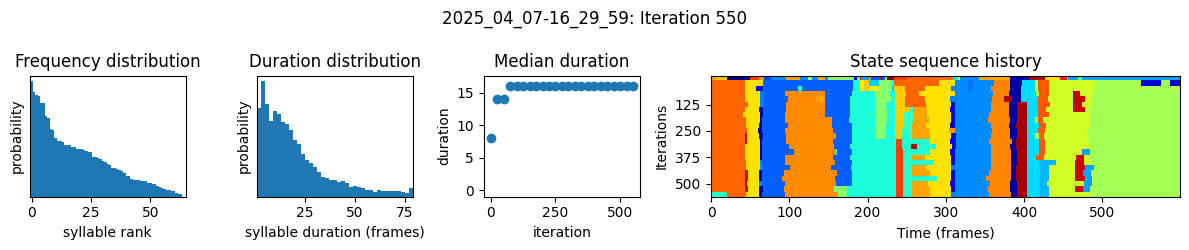

100%|█████████████████████████████████| 501/501 [33:20<00:00,  3.99s/it]


In [27]:
# load model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(
    project_dir, model_name, iteration=num_ar_iters)

# modify kappa to maintain the desired syllable time-scale
model = kpms.update_hypparams(model, kappa=10e5)

# run fitting for an additional 500 iters
model = kpms.fit_model(
    model, data, metadata, project_dir, model_name, ar_only=False, 
    start_iter=current_iter, num_iters=current_iter+500)[0]
    

In [28]:
# sort syllables based on frenquency
kpms.reindex_syllables_in_checkpoint(project_dir, model_name);

Reindexing: 100%|███████████| 23/23 [00:28<00:00,  1.25s/model snapshot]


In [29]:
model, data, metadata, current_iter = kpms.load_checkpoint(project_dir, model_name)
# extract results
results = kpms.extract_results(model, metadata, project_dir, model_name)

Saved results to R:\PBS\LiPatel_Labs\General\kmps\valen\withPorts\2025
_04_07-16_29_59\results.h5


Saving trajectory plots to R:\PBS\LiPatel_Labs\General\kmps\valen\withPorts\2025_04_07-16_29_59\trajectory_plots


Generating trajectory plots: 100%|██████| 48/48 [00:22<00:00,  2.16it/s]


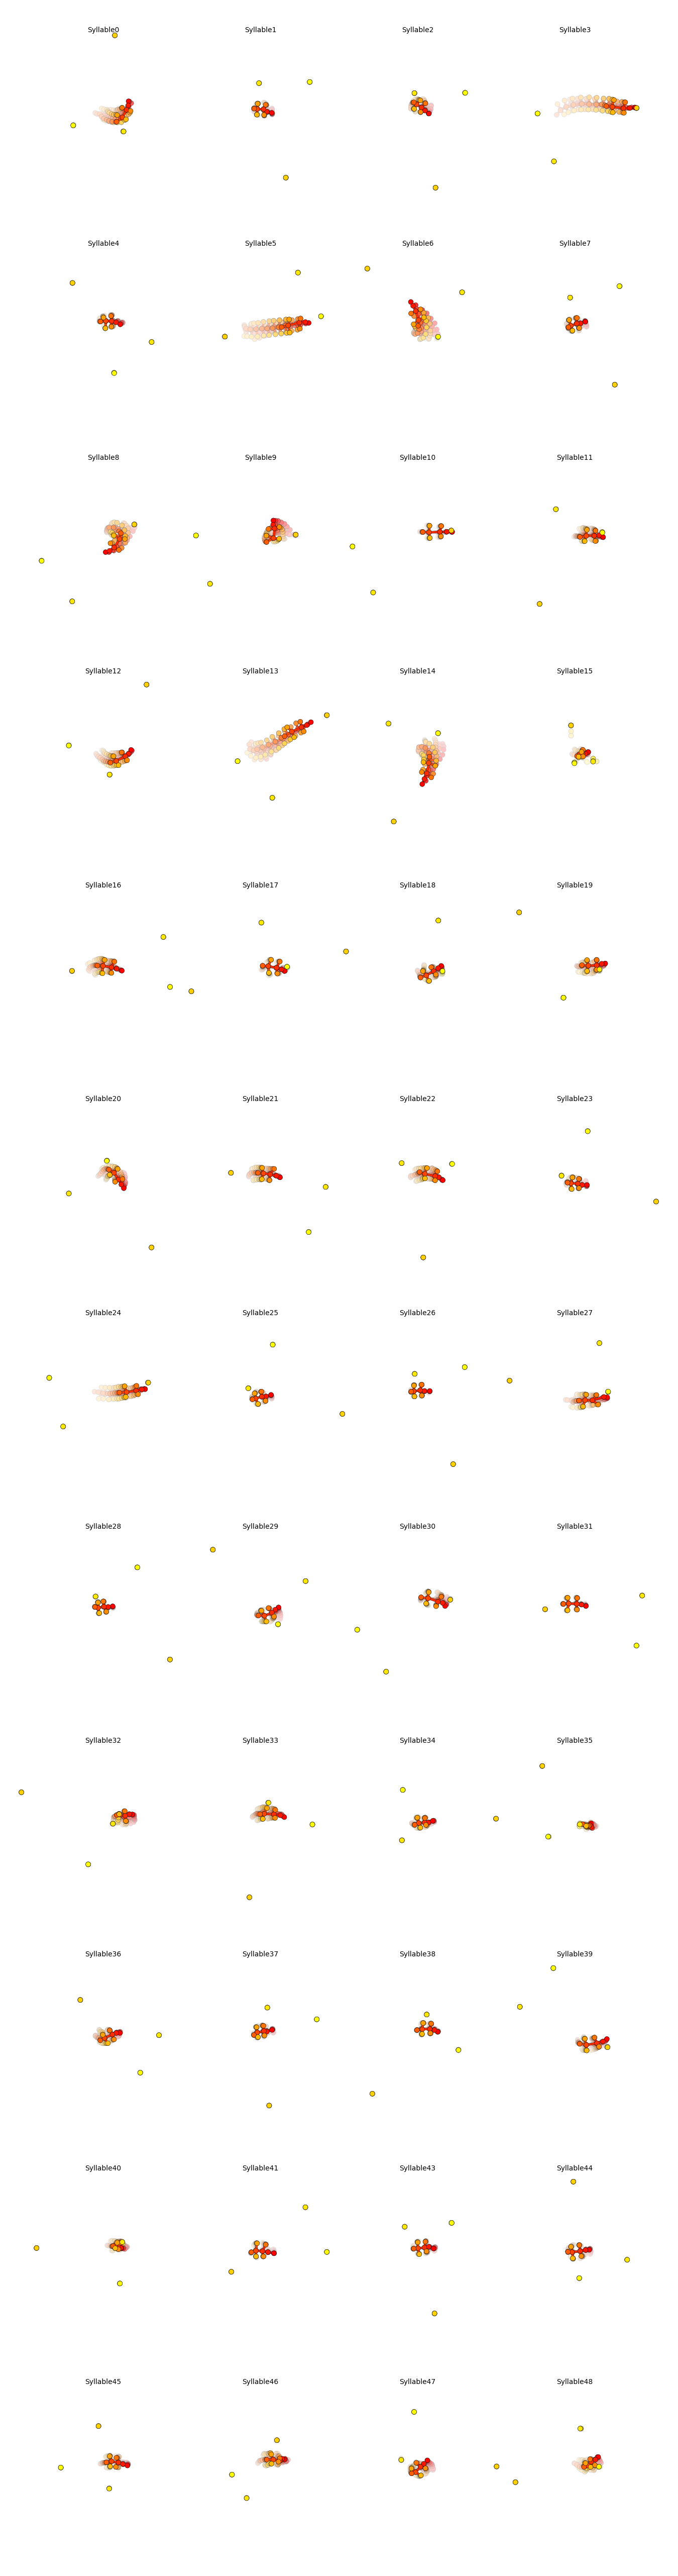

In [30]:
results = kpms.load_results(project_dir, model_name)
kpms.generate_trajectory_plots(coordinates, results, project_dir, model_name, **config())

In [28]:
# optional make movies
kpms.generate_grid_movies(results, project_dir, model_name, coordinates=coordinates, **config());

Writing grid movies to R:\PBS\LiPatel_Labs\General\kmps\Talia\2025_03_13-22_20_45\grid_movies


C:\Users\Lihao\anaconda3\envs\kpms\lib\site-packages\keypoint_moseq\viz.py:1266: UserWarning:


Videos will be downscaled by a factor of 0.54 so that the grid movies
are under 1920 pixels. Use `max_video_size` to increase or decrease
this size limit.





Using window size of 592 pixels


Generating grid movies: 100%|███████████| 31/31 [03:07<00:00,  6.05s/it]
